In [1]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

import tensorflow as tf
import matplotlib.pyplot as plt, numpy as np
import pickle
sess = tf.InteractiveSession()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


We use the ConvNet code provided at:
https://www.tensorflow.org/get_started/mnist/pros

In [2]:
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

# First Convolutional Layer
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

x_image = tf.reshape(x, [-1, 28, 28, 1])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

# Second Convolutional Layer
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

# Densely Connected Layer
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# Dropout
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# Readout Layer
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [3]:
prediction = tf.argmax(y_conv, 1)
softmax = tf.nn.softmax(y_conv)
saver = tf.train.Saver()

This training segment from https://www.tensorflow.org/get_started/mnist/pros is optional, as the model is already saved

In [4]:
# OPTIONAL

with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for i in range(20000):
    batch = mnist.train.next_batch(50)
    if i % 1000 == 0:
      train_accuracy = accuracy.eval(feed_dict={
          x: batch[0], y_: batch[1], keep_prob: 1.0})
      print('step %d, training accuracy %g' % (i, train_accuracy))
    train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

  print('test accuracy %g' % accuracy.eval(feed_dict={
      x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

  save_path = saver.save(sess, "./model/saved_model.ckpt")
  print("Model saved in file %s" % save_path)

step 0, training accuracy 0.1
step 1000, training accuracy 0.98
step 2000, training accuracy 0.98
step 3000, training accuracy 0.98
step 4000, training accuracy 1
step 5000, training accuracy 0.98
step 6000, training accuracy 1
step 7000, training accuracy 1
step 8000, training accuracy 0.98
step 9000, training accuracy 1
step 10000, training accuracy 1
step 11000, training accuracy 1
step 12000, training accuracy 1
step 13000, training accuracy 0.98
step 14000, training accuracy 1
step 15000, training accuracy 1
step 16000, training accuracy 1
step 17000, training accuracy 1
step 18000, training accuracy 1
step 19000, training accuracy 1
test accuracy 0.993
Model saved in file ./model/saved_model.ckpt


With the model trained, we now find 10 images labeled 2, making sure the 10 images are classified as 2 by the trained ConvNet.

INFO:tensorflow:Restoring parameters from ./model/saved_model.ckpt


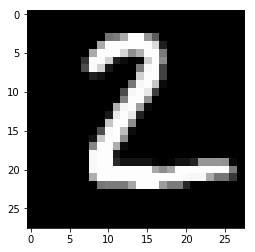

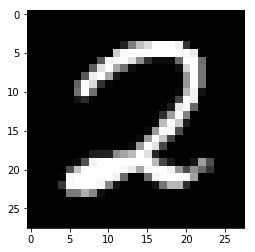

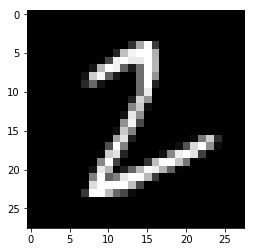

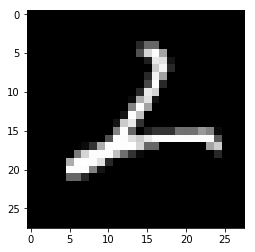

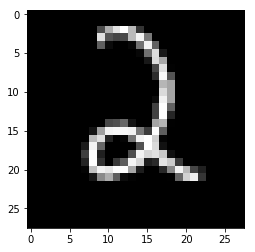

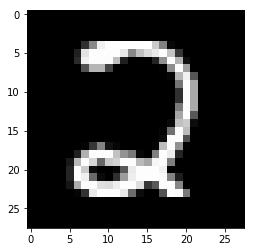

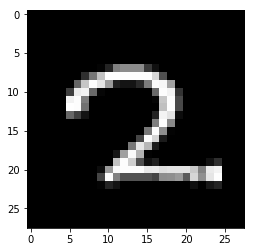

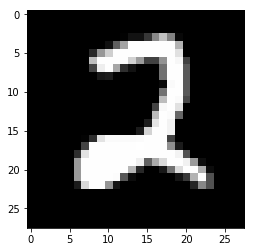

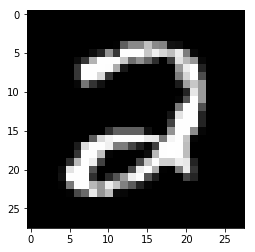

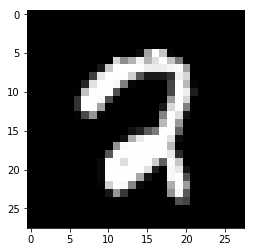

In [5]:
num = 2
target = 6
index = 0
index_list = []
while (len(index_list) < 10):
    if mnist.test.labels[index][num] == 1:
        index_list.append(index)
    index += 1

with tf.Session() as sess:
    saver.restore(sess, "./model/saved_model.ckpt")
    for i in index_list:
        img = mnist.test.images[i]
        plt.imshow(np.reshape(img, [28, 28]), cmap='gray')
        plt.show()
        img = np.reshape(img, [1,784])
        # verify selected images are predicted correctly by trained ConvNet
        assert prediction.eval(feed_dict={x: img, keep_prob: 1.0}) == [num]

We generate adversarial images with the rule: $\mathbf{x}_{\text{adv}} \leftarrow \mathbf{x}_{\text{adv}} - \epsilon \nabla_{\mathbf{x}_{\text{x}}} \left[ \text{CE}(\mathbf{f}_{\mathbf{\theta}}, \mathbf{y}) + \lambda || \mathbf{x} - \mathbf{x}_{\text{adv}} ||_2^2 \right]$,

where CE denotes the cross entropy, $\mathbf{f}_{\mathbf{\theta}}$ is our ConvNet, $\mathbf{y}$ is our target label, and $\mathbf{x}$ is our original image. Notice that we have a l2 regularization term, which is designed to encourage generated image to stay similar to the original image.

INFO:tensorflow:Restoring parameters from ./model/saved_model.ckpt


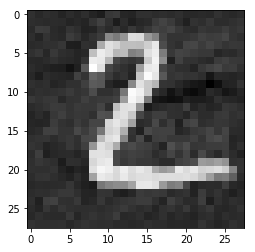

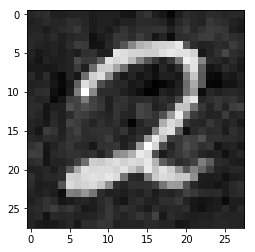

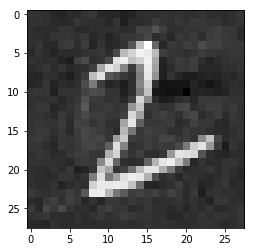

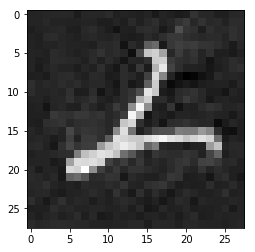

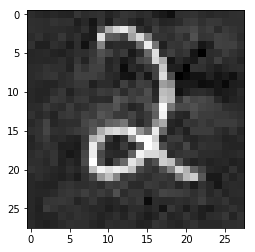

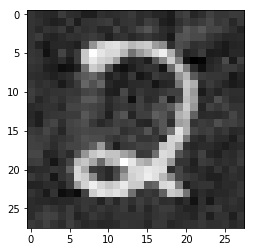

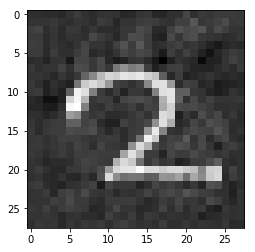

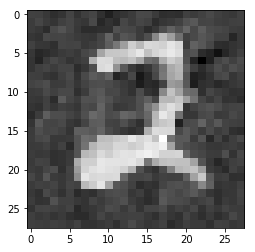

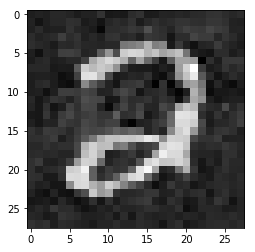

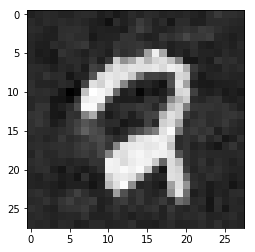

In [6]:
advers_imgs = [] # list of generated adversarial images
epsilon = 0.01 # image optimization step size
reg_strength = 0.9 # how close generated image should be to real input image (lambda in above)
orig_img = tf.placeholder(tf.float32, shape=[1, 784]) # real input image
new_label = np.zeros(10)
new_label[target] = 1
new_label = np.reshape(new_label, [1,10]) # new fake label

loss = cross_entropy + reg_strength * tf.nn.l2_loss(orig_img - x)
grad = tf.gradients(loss, x)[0]

with tf.Session() as sess:
    saver.restore(sess, "./model/saved_model.ckpt")
    
    for index in index_list:
        orig = np.reshape(mnist.test.images[index], [1, 784])
        img = orig.copy()
        assert prediction.eval({x: img, keep_prob: 1.0}) == [num]
        
        for i in range(500):
            grad_val = sess.run(grad, feed_dict={x: img, y_: new_label, orig_img: orig, keep_prob: 1.0})
            img -= (epsilon * grad_val)
            
        advers_imgs.append(img)
        # verify generated image is predicted as target
        assert prediction.eval({x: img, keep_prob: 1.0}) == [target]

# display generated adversarial images
for image in advers_imgs:
    plt.imshow(np.reshape(image, [28, 28]), cmap='gray')
    plt.show()

Next, we create the delta images, which are the difference between the orginal images and the generated images.

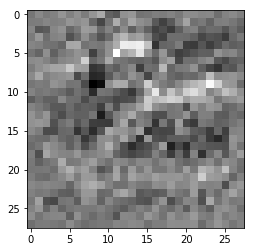

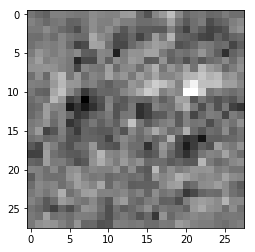

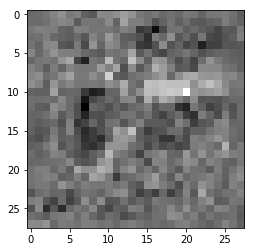

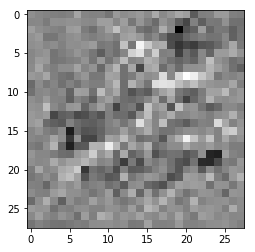

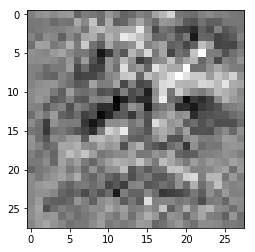

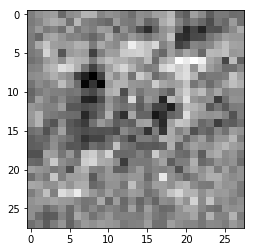

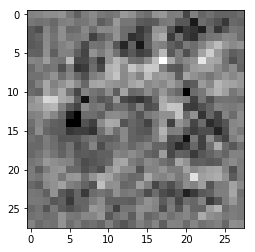

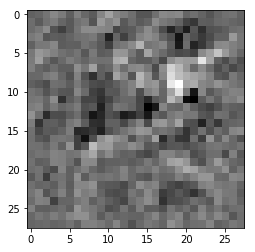

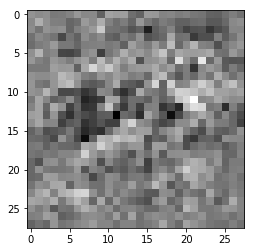

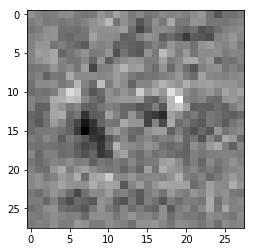

In [7]:
delta_imgs = []

for i in range(len(index_list)):
    original_image = mnist.test.images[index_list[i]]
    adversarial_image = advers_imgs[i]
    delta_image = original_image - adversarial_image
    delta_imgs.append(delta_image)
    plt.imshow(np.reshape(delta_image, [28,28]), cmap='gray')
    plt.show()

We now save each original "2" digit image, delta image, and adversarial image.
This is optional, since images are already saved.

In [8]:
# OPTIONAL

from scipy.misc import imsave

for i in range(len(index_list)):
    imsave('./images/orig' + str(i) + '.png', mnist.test.images[index_list[i]].reshape([28,28]))
    imsave('./images/delta' + str(i) + '.png', delta_imgs[i].reshape([28,28]))
    imsave('./images/final' + str(i) + '.png', advers_imgs[i].reshape([28,28]))

We examine the trained ConvNet's predictions and confidence of predictions on each original image, delta image, and adversarial image

In [9]:
# ConvNet's predictions
pred_orig = []
pred_delta = []
pred_final = []
# ConvNet's confidence on each prediction
confidence_orig = []
confidence_delta = []
confidence_final = []

with tf.Session() as sess:
    saver.restore(sess, "./model/saved_model.ckpt")
    
    for i in range(len(index_list)):
        orig = mnist.test.images[index_list[i]].reshape([1,784])
        delta = delta_imgs[i]
        final = advers_imgs[i]
        
        pred_orig.append(prediction.eval({x: orig, keep_prob: 1.0})[0])
        pred_delta.append(prediction.eval({x: delta, keep_prob: 1.0})[0])
        pred_final.append(prediction.eval({x: final, keep_prob: 1.0})[0])
                
        confidence_orig.append(softmax.eval({x: orig, keep_prob: 1.0})[0].max())
        confidence_delta.append(softmax.eval({x: delta, keep_prob: 1.0})[0].max())
        confidence_final.append(softmax.eval({x: final, keep_prob: 1.0})[0].max())

print('Prediction and confidence on original images:')
print(pred_orig)
print(confidence_orig)

print('\nPrediction and confidence on delta images:')
print(pred_delta)
print(confidence_delta)

print('\nPrediction and confidence on adversarial images:')
print(pred_final)
print(confidence_final)

INFO:tensorflow:Restoring parameters from ./model/saved_model.ckpt
Prediction and confidence on original images:
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[1.0, 0.99999988, 0.99999964, 0.99985933, 1.0, 0.99999988, 0.99999821, 1.0, 0.99999988, 0.99881434]

Prediction and confidence on delta images:
[7, 5, 5, 1, 5, 5, 5, 7, 2, 5]
[0.34034473, 0.44247255, 0.6483773, 0.25258356, 0.62482458, 0.30105445, 0.35822451, 0.49006963, 0.48965466, 0.50561655]

Prediction and confidence on adversarial images:
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
[0.89977533, 0.85335624, 0.90912086, 0.89868873, 0.88622922, 0.81072921, 0.8387205, 0.81302011, 0.82226121, 0.85844702]


We can estimate our model's uncertainty with its predictions by examining the Monte Carlo estimates of the mean and variance of our predictions with dropout at test time, following [1]. Under this scheme, we see that the trained model gives consistent answers to a real image. However, given an adversarial image, the trained model gives inconsistent answers, and the final answer may not be the label intended, which in this case is 6.

[1] Yarin Gal and Zoubin Ghahramani. Dropout as a Bayesian Approximation: Representing model uncertainty in deep learning. ICML, 2016.

INFO:tensorflow:Restoring parameters from ./model/saved_model.ckpt


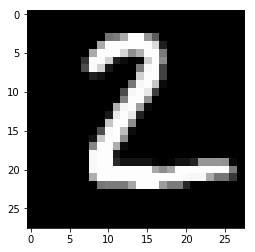

Prediction from trained model: 2

Trial 1 with dropout at test time
Prediction from trained model with dropout at test time: 2.0
Variance on prediction: 0.0

Trial 2 with dropout at test time
Prediction from trained model with dropout at test time: 2.0
Variance on prediction: 0.0


In [10]:
# Get uncertainty estimates for a "2" digit image
with tf.Session() as sess:
    saver.restore(sess, "./model/saved_model.ckpt")
    pred = []
    img = mnist.test.images[index_list[0]].reshape([1,784])
    plt.imshow(np.reshape(img, [28, 28]), cmap='gray')
    plt.show()
    print('Prediction from trained model: %s' % prediction.eval({x: img, keep_prob: 1.0})[0])
    print('\nTrial 1 with dropout at test time')
    for _ in range(10):
        pred.append(prediction.eval({x: img, keep_prob: 0.5}))
    print('Prediction from trained model with dropout at test time: %s' % np.mean(pred))
    print('Variance on prediction: %s' % np.var(pred))
    
    print('\nTrial 2 with dropout at test time')
    pred = []
    for _ in range(10):
        pred.append(prediction.eval({x: img, keep_prob: 0.5}))
    print('Prediction from trained model with dropout at test time: %s' % np.mean(pred))
    print('Variance on prediction: %s' % np.var(pred))

INFO:tensorflow:Restoring parameters from ./model/saved_model.ckpt


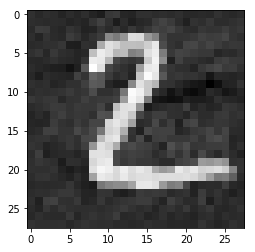

Prediction from trained model: 6

Trial 1 with dropout at test time
Prediction from trained model with dropout at test time: 4.4
Variance on prediction: 3.84

Trial 2 with dropout at test time
Prediction from trained model with dropout at test time: 3.6
Variance on prediction: 3.84


In [11]:
# Get uncertainty estimates for the corresponding fake 6 image
with tf.Session() as sess:
    saver.restore(sess, "./model/saved_model.ckpt")
    new_pred = []
    adv_img = advers_imgs[0]
    plt.imshow(np.reshape(adv_img, [28, 28]), cmap='gray')
    plt.show()
    print('Prediction from trained model: %s' % prediction.eval({x: adv_img, keep_prob: 1.0})[0])
    print('\nTrial 1 with dropout at test time')
    for _ in range(10):
        new_pred.append(prediction.eval({x: adv_img, keep_prob: 0.5}))
    print('Prediction from trained model with dropout at test time: %s' % np.mean(new_pred))
    print('Variance on prediction: %s' % np.var(new_pred))
    
    print('\nTrial 2 with dropout at test time')
    new_pred = []
    for _ in range(10):
        new_pred.append(prediction.eval({x: adv_img, keep_prob: 0.5}))
    print('Prediction from trained model with dropout at test time: %s' % np.mean(new_pred))
    print('Variance on prediction: %s' % np.var(new_pred))

Finally, we see if a novelty dectection model such as a one class SVM can detect fake 6 images. This is not a practical method to check if an image is adversarial. This is because we must input a suspected image for each possible class, which will be impractical given many classes. In this case, however, we need only train a single one class SVM with real 6 digits.

The data generation segment below is optional, since all training and test data are already saved.

In [12]:
# OPTIONAL

# Initialize training and test datasets
X_train = np.array(mnist.train.images[0].reshape([1,784])) # real digits from training set that are labeled 6
X_fake = np.array(mnist.train.images[0].reshape([1,784])) # fake 6 digits
X_real_non_six =np.array(mnist.train.images[0].reshape([1,784])) # real digits from test set that are not labeled 6
X_real_six = np.array(mnist.train.images[0].reshape([1,784])) # real digits from test set that are labeled 6

# Build X_train data
for i in range(mnist.train.images.shape[0]):
    if mnist.train.labels[i][target] == 1:
        X_train = np.append(X_train, mnist.train.images[i].reshape([1,784]), axis=0)

X_train = np.delete(X_train, (0), axis=0) # delete first row
print(X_train.shape)
pickle.dump(X_train, open("./sklearn_data/X_train.p", "wb"))

# Build X_fake data
for i in range(10):
    X_fake = np.append(X_fake, advers_imgs[i].reshape([1,784]), axis=0)

X_fake = np.delete(X_fake, (0), axis=0) # delete first row
print(X_fake.shape)
pickle.dump(X_fake, open("./sklearn_data/X_fake.p", "wb"))

# Build X_real_non_six data
for i in range(mnist.test.images.shape[0]):
    if mnist.test.labels[i][target] == 0:
        X_real_non_six = np.append(X_real_non_six, mnist.test.images[i].reshape([1,784]), axis=0)

X_real_non_six = np.delete(X_real_non_six, (0), axis=0) # delete first row
print(X_real_non_six.shape)
# fix pickle protocol to ensure size is manageable
pickle.dump(X_real_non_six, open("./sklearn_data/X_real_non_six.p", "wb"), protocol=pickle.HIGHEST_PROTOCOL)

# Build X_real_six data
for i in range(mnist.test.images.shape[0]):
    if mnist.test.labels[i][target] == 1:
        X_real_six = np.append(X_real_six, mnist.test.images[i].reshape([1,784]), axis=0)

X_real_six = np.delete(X_real_six, (0), axis=0) # delete first row
print(X_real_six.shape)
pickle.dump(X_real_six, open("./sklearn_data/X_real_six.p", "wb"))

(5417, 784)
(10, 784)
(9042, 784)
(958, 784)


The one class SVM can correctly identify most adversarial images. However, it can only correctly identify real 6 images slightly better than chance. Due to its high false positive error rate, we see that the one class SVM with a linear kernel is not a good model to find adversarial images with this data.

In [13]:
from sklearn import svm

# Load Pickled files
X_train = pickle.load(open("./sklearn_data/X_train.p", "rb"))
X_fake = pickle.load(open("./sklearn_data/X_fake.p", "rb"))
X_real_non_six = pickle.load(open("./sklearn_data/X_real_non_six.p", "rb"))
X_real_six = pickle.load(open("./sklearn_data/X_real_six.p", "rb"))

clf = svm.OneClassSVM(kernel="linear")
clf.fit(X_train)
y_pred_fake = clf.predict(X_fake)
y_pred_real_non_six = clf.predict(X_real_non_six)
y_pred_real_six = clf.predict(X_real_six)

n_fake_found = y_pred_fake[y_pred_fake == -1].size
n_real_non_six_found = y_pred_real_non_six[y_pred_real_non_six == -1].size
n_error_real_six = y_pred_real_six[y_pred_real_six == -1].size

print('one class SVM correctly found %s images out of 10 adversarial images' % n_fake_found)
print('one class SVM correctly found %s images out of %s non-6 images' % (n_real_non_six_found, X_real_non_six.shape[0]))
print('one class SVM failed to identify %s images as 6 out of %s real 6 images' % (n_error_real_six, X_real_six.shape[0]))

one class SVM correctly found 9 images out of 10 adversarial images
one class SVM correctly found 7786 images out of 9042 non-6 images
one class SVM failed to identify 440 images as 6 out of 958 real 6 images


The one class SVM with an rbf kernel more agressively labels images as non-6. So it has an even higher false positive error rate.

In [14]:
clf2 = svm.OneClassSVM(kernel="rbf")
clf2.fit(X_train)
y_pred_fake2 = clf2.predict(X_fake)
y_pred_real_non_six2 = clf2.predict(X_real_non_six)
y_pred_real_six2 = clf2.predict(X_real_six)

n_fake_found2 = y_pred_fake2[y_pred_fake2 == -1].size
n_real_non_six_found2 = y_pred_real_non_six2[y_pred_real_non_six2 == -1].size
n_error_real_six2 = y_pred_real_six2[y_pred_real_six2 == -1].size

print('one class SVM correctly found %s images out of 10 adversarial images' % n_fake_found2)
print('one class SVM correctly found %s images out of %s non-6 images' % (n_real_non_six_found2, X_real_non_six.shape[0]))
print('one class SVM failed to identify %s images as 6 out of %s real 6 images' % (n_error_real_six2, X_real_six.shape[0]))

one class SVM correctly found 9 images out of 10 adversarial images
one class SVM correctly found 9032 images out of 9042 non-6 images
one class SVM failed to identify 515 images as 6 out of 958 real 6 images
